In [1]:
import sys
sys.path.append('..')
# reload local packages automatically
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)

# Import packages.
import cvxpy as cp
import numpy as np

import matplotlib.pyplot as plt


from opentn.transformations import create_kitaev_liouvillians, exp_operator_dt, factorize_psd, super2choi
d, N = 2, 4
dim = d**N
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=1e-2)
tau = 4
superops_exp = []
for i, op in enumerate([Lvec, Lvec_odd, Lvec_even]):
    if i == 1:
        superops_exp.append(exp_operator_dt(op, tau/2, 'jax'))
    else:
        superops_exp.append(exp_operator_dt(op, tau, 'jax'))
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = superops_exp

X1 = factorize_psd(psd=super2choi(exp_Lvec_odd), tol=1e-12)
X2 = factorize_psd(psd=super2choi(exp_Lvec_even), tol=1e-12)

from opentn.optimization import gds, frobenius_norm, model_Ys, compute_loss
cost_n4, grads_n4, xi_n4 = gds(fn=compute_loss, x0=[X1, X2, X1], iter=int(2e3), loss_fn=frobenius_norm, model=model_Ys, rate=1.5e-9, exact = exp_Lvec, show_cost=False)
print(cost_n4[0])
print(cost_n4[-1])

2.6383007149418305e-07
1.4977787039695335e-07


In [21]:
from opentn.transformations import super2choi, choi_composition
from opentn.optimization import small2zero
from scipy import sparse

# rest of matrices optimized with GSD
X1_gds, X2_gds, X3_gds = xi_n4[-1]
Y1_gds = X1_gds@X1_gds.conj().T
Y2_gds = X2_gds@X2_gds.conj().T
Y3_gds = X3_gds@X3_gds.conj().T

tol = 1e-12

# rhs to which we want to approximate
rhs = np.asarray(super2choi(superop=exp_Lvec, dim=dim))
# srhs = sparse.csr_matrix(rhs) # small2zero was deleted
srhs = sparse.csr_matrix(small2zero(rhs, tol=tol)) # small2zero was deleted
srhs = srhs.astype(np.float64)

In [22]:
from opentn.transformations import link_product_cvxpy
Y1_cvxpy = cp.Variable((dim**2,dim**2), PSD=True)
C2 = choi_composition(small2zero(Y2_gds, tol), small2zero(Y3_gds, tol))
lhs = link_product_cvxpy(C1=Y1_cvxpy, C2=C2, dim=dim, transpose=1, optimization=True)
cost = cp.norm(lhs - srhs, "fro")
prob = cp.Problem(cp.Minimize(cost))
Y1_cvxpy.value = small2zero(Y1_gds, tol=tol).astype(np.float64) 
cost.value

/var/folders/lv/986s3mp97gv9n3rb757bg87m0000gn/T/ipykernel_9055/826646750.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  Y1_cvxpy.value = small2zero(Y1_gds, tol=tol).astype(np.float64)


1.4977447043603566e-07

In [23]:
prob.solve(solver=cp.SCS, verbose=True, canon_backend=cp.SCIPY_CANON_BACKEND, eps=tol)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Jul 29 08:31:32 PM: Your problem has 65536 variables, 0 constraints, and 0 parameters.
(CVXPY) Jul 29 08:31:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 29 08:31:32 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 29 08:31:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 29 08:31:32 PM: Compiling problem (target solver=SCS).
(CVXPY) Jul 29 08:31:32 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jul 29 08:57:31 PM: Problem status: optimal_inaccurate
(CVXPY) Jul 29 08:57:31 PM: Optimal value: 9.519e-08
(CVXPY) Jul 29 08:57:31 PM: Compilation took 6.611e+02 seconds
(CVXPY) Jul 29 08:57:31 PM: Solver (including time spent in interface) took 8.961e+02 seconds


9.518505958793648e-08

In [28]:
# checking if the solution with and without approximation coincide
# 1. all have small2zero except solution. (should coincide with the output of solver)
print(frobenius_norm(choi_composition(Y1_cvxpy.value, C2), small2zero(rhs, tol=tol)))
# 2. all have small2zero including solution. Due to approximation here, the value increases a bit
print(frobenius_norm(choi_composition(small2zero(Y1_cvxpy.value, tol=tol), C2), small2zero(rhs, tol=tol)))
# 3. none of them have small2zero
print(frobenius_norm(choi_composition(Y1_cvxpy.value, choi_composition(Y2_gds, Y3_gds)), rhs))

9.518505960679793e-08
9.518505947521337e-08
9.518499221133648e-08


old values with eps=1e-9
- 9.517953776939443e-08
- 9.518249209451488e-08
- 9.521364641951719e-08

In [34]:
# verying the rank of: initial_guess, gds_sol, cvx solution w/and without small2zero
max_idx = 16
for op in [super2choi(exp_Lvec_odd), X1@X1.conj().T, Y1_gds, Y1_cvxpy.value, small2zero(Y1_cvxpy.value, tol=tol)]:
    print(np.linalg.matrix_rank(op, tol=tol))
    print(np.sort(np.linalg.svd(op, compute_uv=False))[::-1][:max_idx])
    print('----')


4
[1.59601247e+01 1.99252079e-02 1.99252079e-02 2.48753638e-05
 9.14980688e-15 8.31005402e-15 8.28778104e-15 7.68898909e-15
 5.05313981e-15 4.30617828e-15 4.16892000e-15 3.72903726e-15
 3.42133722e-15 3.09273854e-15 2.96987622e-15 2.80821003e-15]
----
4
[1.59601247e+01 1.99252079e-02 1.99252079e-02 2.48753638e-05
 7.95281221e-15 4.45619364e-15 4.15294601e-15 3.74630065e-15
 3.38415367e-15 3.00980011e-15 2.78457911e-15 2.75926410e-15
 2.62875443e-15 2.57327522e-15 2.56723560e-15 2.12727961e-15]
----
4
[1.59601248e+01 1.99251812e-02 1.99251787e-02 2.48753821e-05
 7.40452593e-15 6.23416821e-15 5.78733966e-15 5.45129161e-15
 5.02854100e-15 4.95731989e-15 4.56542003e-15 4.34589312e-15
 4.19879763e-15 4.02361484e-15 3.80645554e-15 3.57183712e-15]
----
14
[1.59601248e+01 1.99251772e-02 1.99251750e-02 2.48854409e-05
 5.53046517e-08 4.73911389e-08 4.47700891e-08 4.04551273e-08
 3.85097222e-08 1.87524061e-08 1.35363867e-08 8.17210044e-09
 2.73744317e-12 1.04393719e-12 2.61322204e-13 1.91729697e-

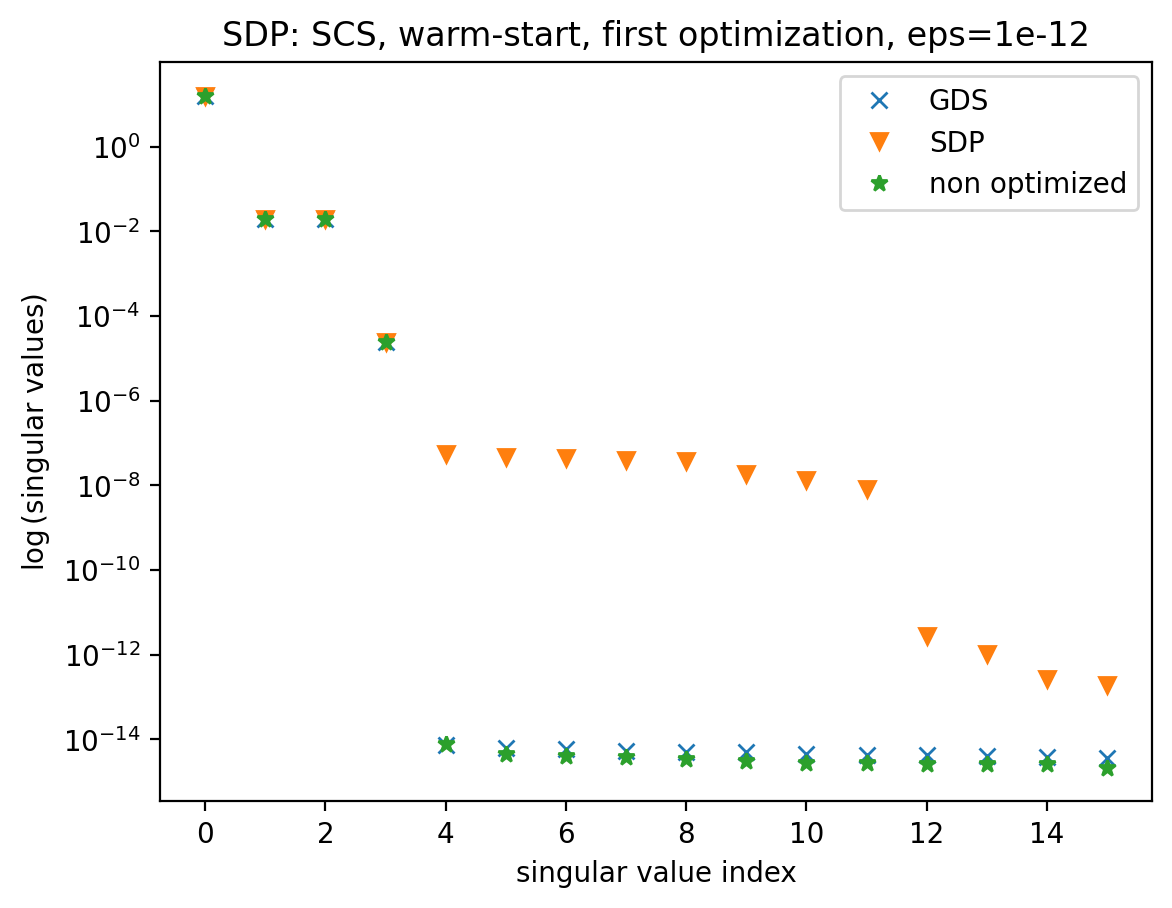

In [38]:
plt.figure(dpi=200)
plt.title(f'SDP: SCS, warm-start, first optimization, eps={tol}')
plt.ylabel(r'$\log$(singular values)')
plt.xlabel(r'singular value index')
plt.semilogy(np.linalg.svd(Y1_gds, compute_uv=False)[:max_idx], 'x', label='GDS')
plt.semilogy(np.linalg.svd(Y1_cvxpy.value, compute_uv=False)[:max_idx], 'v', label='SDP')
plt.semilogy(np.linalg.svd(X1@X1.conj().T, compute_uv=False)[:max_idx], '*', label='non optimized')
plt.legend()

In [39]:
with open(f'Y1_scs_warm_gds_eps_{tol}.npy', 'wb') as f:
    np.save(f, Y1_cvxpy.value)